# **Homework 3**


---


## **CSCE 633 Machine Learning**


---



## **Team members:**


1. Rohan Chaudhury, UIN: 432001358
2. Apurva Purushotama, UIN: 832000625
3. Abhishek Sinha, UIN:232003268
4. Sherine Davis Kozhikadan, UIN: 629009750
5. Sai Harini Voruganti, UIN: 730007811




The goal is to build machine learning models to estimate one’s public speaking anxiety from bio-
behavioral data. The data comes from the VerBio dataset, which was collected with the goal to
better understand individuals’ affective responses while performing public speaking tasks. More
details about the dataset, including the experimental setup and type of data, can be found here:
https://hubbs.engr.tamu.edu/resources/verbio-dataset/.
The data is provided in Google Drive in “Homework 5” folder and includes 55 participants. We
have one presentation for each participant, which results in 55 data samples. You are provided
with two types of data.
1. The “data.csv” file that contains a set of bio-behavioral features (i.e., skin conductance
level, skin conductance response amplitude, skin conductance response frequency, heart
rate, wrist acceleration, interbeat interval, speech energy, 12 speech mel-frequency cep-
stral coefficients (MFCCs), speech zero crossing rate, speech voicing probability, speech
fundamental frequency (F0), speech pause frequency), label (i.e., state anxiety), and par-
ticipants’ language information (i.e., native/non-native English speaker). Each row in the
csv file corresponds to one data point. The bio-behavioral features were computed based
on the entire presentation for each participant.
2. A set of files titled “EDA PPT PXXX.xlsx,” where XXX is the participant’s ID, that
include temporal values of participants’ electrodermal activity (EDA) signals (i.e., sweat
activity from the wrist) collected during the presentation sampled at 4Hz (i.e., 4 values
per second).
3. A set of files titled “HR PPT PXXX.xlsx,” where XXX is the participant’s ID, that
include temporal values of participants’ heart rate (HR) signals collected during the pre-
sentation sampled at 1Hz (i.e., 1 value per second).

#**Question(a): Data pre-processing and exploration**

---



### Identify missing data values and replace them with the corresponding feature mean. You can also experiment with any other feature imputation method. Provide visualizations of the features with respect to the state anxiety label (e.g., overlaying histograms, scatter plots), and quantify associations between the features and the label (e.g., via correlation coefficient).


---




In [ ]:
import pandas as pd
import numpy as np
import os
import math 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
def getFullPath(path):
  return '{}{}'.format(DRIVE_BASE_PATH, path)

DRIVE_BASE_PATH = os.getcwd() + '/'
nonTemporalData = pd.read_csv(getFullPath('data.csv')).set_index('PID')
nonTemporalData = nonTemporalData.apply(lambda x: x.fillna(x.mean()))

def normalize(img):
  mean = img.mean()
  std = img.std()
  img = (img - mean)/std
  return img

def normalizeMaxMin(img):
  mx = max(abs(img))
  img = (img)/mx
  return img

def getMeanTS(pid, dtype='EDA'):
  fileNameTemplate = '{}_PPT_{}.xlsx'
  df = pd.read_excel(getFullPath(fileNameTemplate.format(dtype, pid)))[dtype]
  return df.mean()

def getVarianceTS(pid, dtype='EDA'):
  fileNameTemplate = '{}_PPT_{}.xlsx'
  df = pd.read_excel(getFullPath(fileNameTemplate.format(dtype, pid)))[dtype]
  return df.var()

def getModeTS(pid, dtype='EDA'):
  fileNameTemplate = '{}_PPT_{}.xlsx'
  df = pd.read_excel(getFullPath(fileNameTemplate.format(dtype, pid)))[dtype]
  return df.mode().iloc[0]

nonTemporalData['meanEDA'] = nonTemporalData.apply(lambda x: getMeanTS(x.name, dtype='EDA'), axis=1)
nonTemporalData['varEDA'] = nonTemporalData.apply(lambda x: getVarianceTS(x.name, dtype='EDA'), axis=1)
nonTemporalData['modeEDA'] = nonTemporalData.apply(lambda x: getModeTS(x.name, dtype='EDA'), axis=1)

nonTemporalData['meanHR'] = nonTemporalData.apply(lambda x: getMeanTS(x.name, dtype='HR'), axis=1)
nonTemporalData['varHR'] = nonTemporalData.apply(lambda x: getVarianceTS(x.name, dtype='HR'), axis=1)
nonTemporalData['modeHR'] = nonTemporalData.apply(lambda x: getModeTS(x.name, dtype='HR'), axis=1)

In [ ]:
contColumns = ['SCL', 'SCRamp', 'SCRfreq', 'HR', 'BVP', 'TEMP', 'ACC', 'IBI',
       'RMSenergy', 'mfcc[1]', 'mfcc[2]', 'mfcc[3]', 'mfcc[4]', 'mfcc[5]',
       'mfcc[6]', 'mfcc[7]', 'mfcc[8]', 'mfcc[9]', 'mfcc[10]', 'mfcc[11]',
       'mfcc[12]', 'zcr', 'voiceProb', 'F0', 'pause_frequency', 
       'meanEDA', 'varEDA', 'modeEDA', 'meanHR', 'varHR',
       'modeHR']

for col in contColumns:
  nonTemporalData[col] = normalize(nonTemporalData[col])

In [ ]:
data = nonTemporalData

In [ ]:
def displayPlots():
  fig, ax = plt.subplots(nrows=7, ncols=5, figsize=(20,25))
  colIndex = 0
  flag = False
  for row in ax:
      for col in row:
          if colIndex == len(data.columns)-1:
              flag=True
              break
          col.plot(data.iloc[:,colIndex], data.loc[:,'StateAnxiety'])
          col.set_xlabel('StateAnxiety')
          col.set_ylabel(data.columns[colIndex])
          colIndex = colIndex+1
      if flag:
          break
  plt.show()

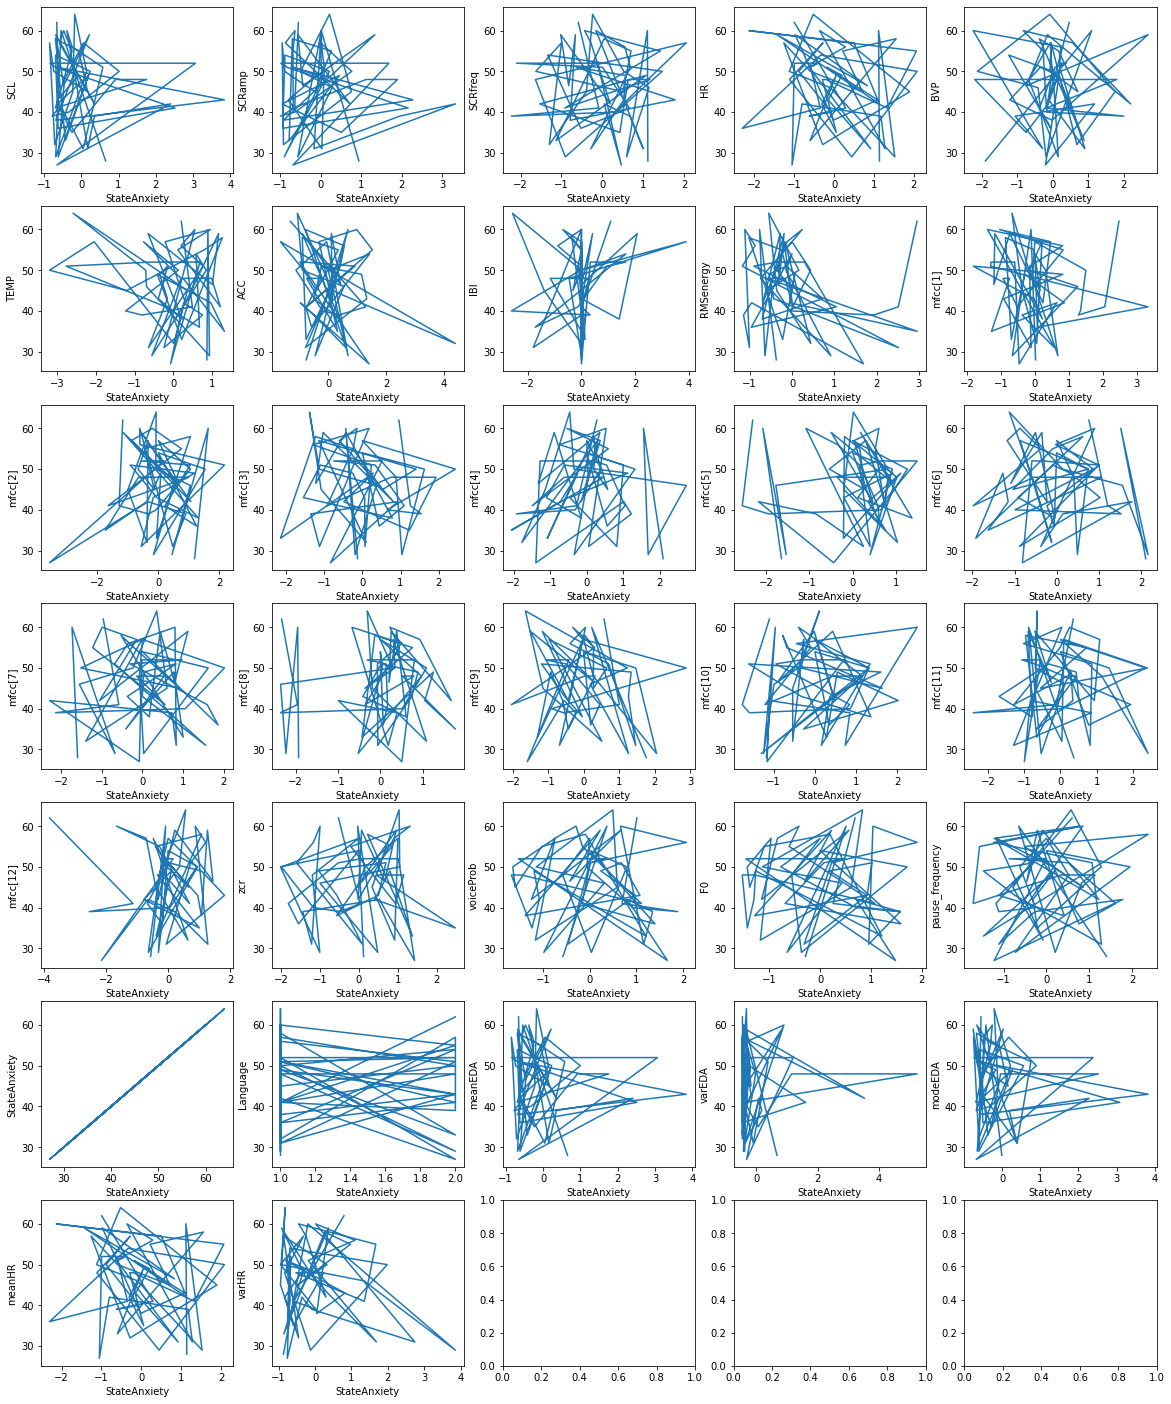

In [ ]:
displayPlots()

In [ ]:
def displayScatterPlots():
  fig, ax = plt.subplots(nrows=7, ncols=5, figsize=(20,25))
  colIndex = 0
  flag = False
  for row in ax:
      for col in row:
          if colIndex ==  len(data.columns)-1:
              flag=True
              break
          col.scatter(data.iloc[:,colIndex], data.loc[:,'StateAnxiety'])
          col.set_xlabel('StateAnxiety')
          col.set_ylabel(data.columns[colIndex])
          colIndex = colIndex+1
      if flag:
          break
  plt.show()

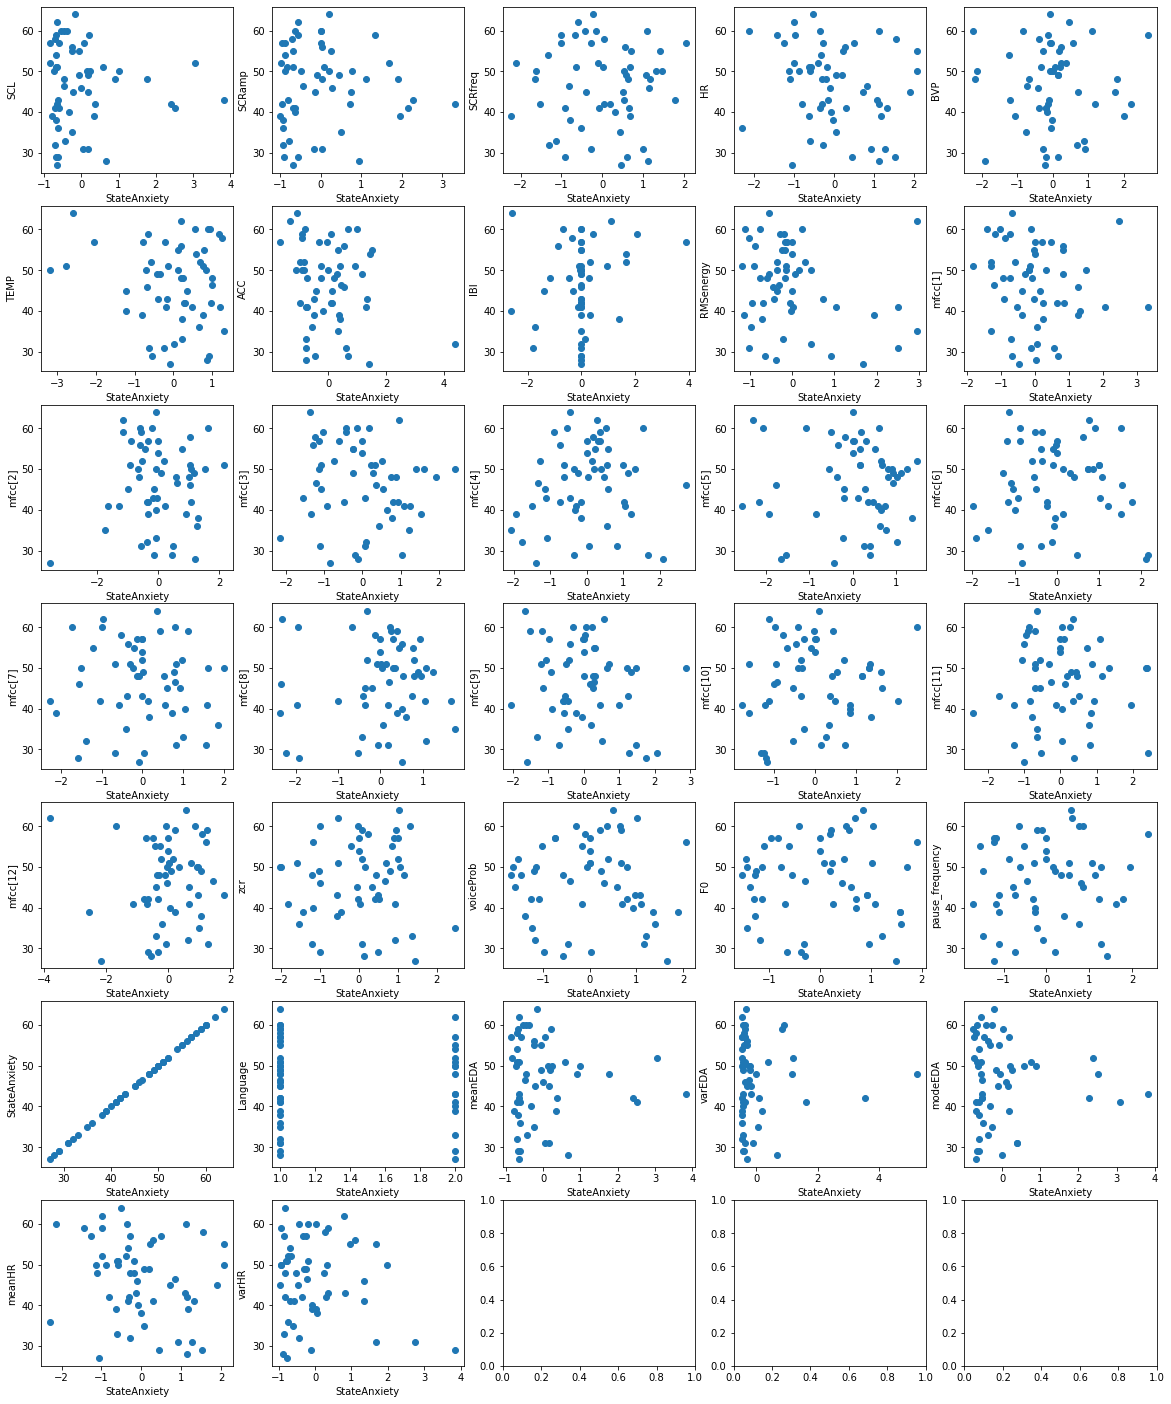

In [ ]:
displayScatterPlots()

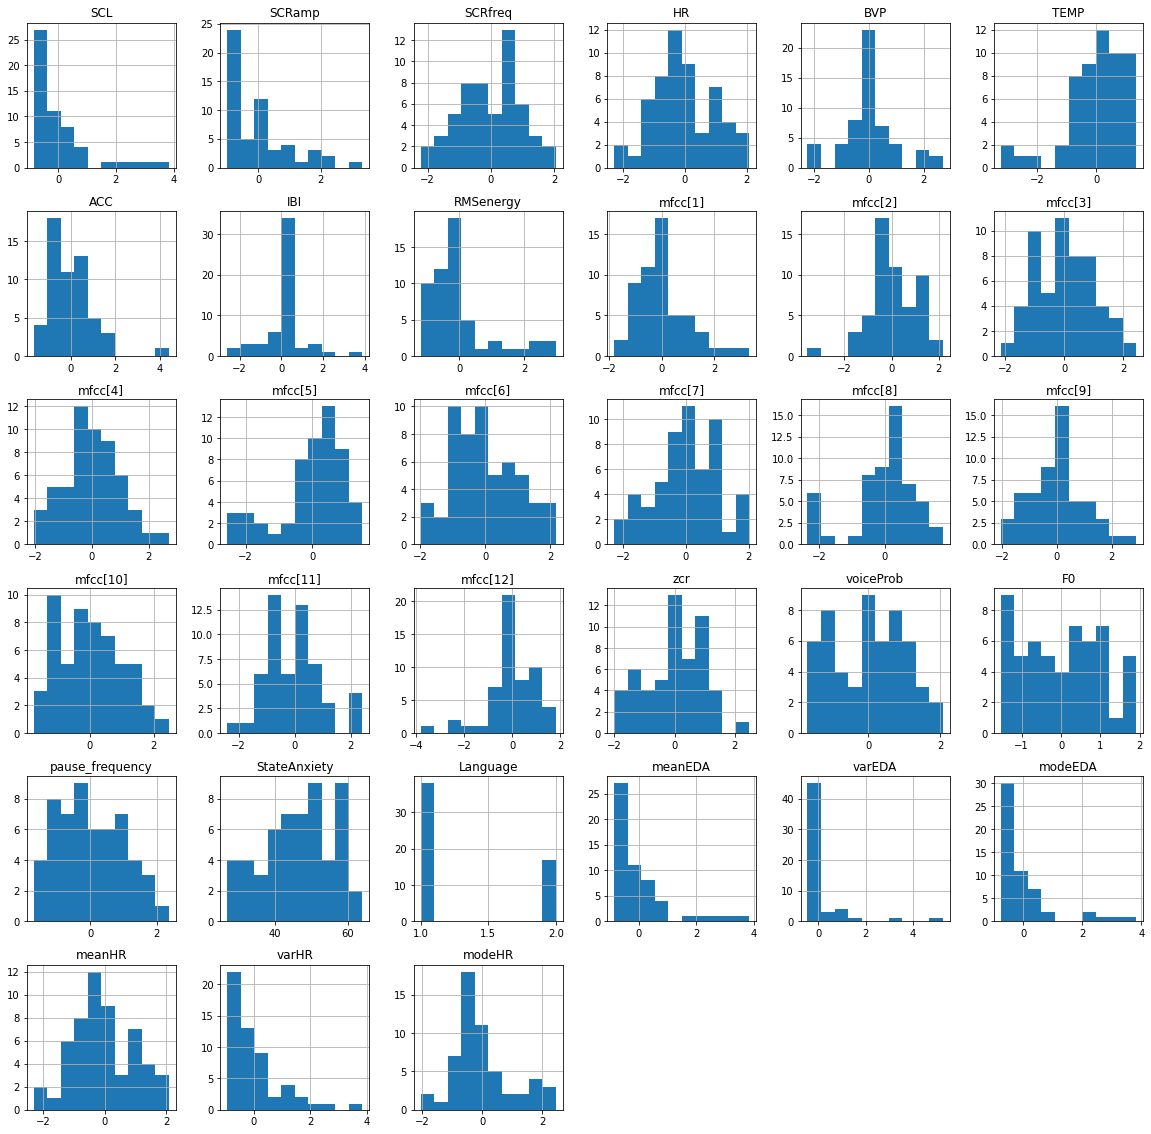

In [ ]:
data.hist(figsize=(20, 20))
plt.show()

In [ ]:
def showCorrelations():
  corrData = []
  for x in nonTemporalData.keys():
    if x == 'StateAnxiety':
      continue
    corrData.append(('StateAnxiety', x, nonTemporalData['StateAnxiety'].corr(nonTemporalData.loc[:, x], method = 'pearson')))
  corrDf = pd.DataFrame(corrData, columns=['Label', 'Feature', 'Corr']).set_index('Feature').sort_values('Corr')
  corrDf['Abs'] = abs(corrDf['Corr'])
  return corrDf.sort_values('Abs',ascending=False)


In [ ]:
showCorrelations()

Label      Corr       Abs
Feature                                          
RMSenergy        StateAnxiety -0.236090  0.236090
meanHR           StateAnxiety -0.217042  0.217042
HR               StateAnxiety -0.217042  0.217042
ACC              StateAnxiety -0.216606  0.216606
IBI              StateAnxiety  0.183156  0.183156
mfcc[9]          StateAnxiety -0.167732  0.167732
varHR            StateAnxiety -0.165264  0.165264
mfcc[1]          StateAnxiety -0.125903  0.125903
mfcc[10]         StateAnxiety  0.125598  0.125598
TEMP             StateAnxiety -0.120541  0.120541
mfcc[3]          StateAnxiety -0.105996  0.105996
mfcc[4]          StateAnxiety  0.096626  0.096626
modeHR           StateAnxiety -0.093267  0.093267
mfcc[2]          StateAnxiety  0.081256  0.081256
pause_frequency  StateAnxiety  0.077460  0.077460
Language         StateAnxiety -0.065444  0.065444
mfcc[8]          StateAnxiety  0.058475  0.058475
meanEDA          StateAnxiety -0.050162  0.050162
SCL              StateAnxiety -0.049805  0.049805
modeEDA          StateAnxiety -0.049739  0.049739
mfcc[12]         StateAnxiety  0.045374  0.045374
voiceProb        StateAnxiety -0.042014  0.042014
mfcc[7]          StateAnxiety -0.037644  0.037644
zcr              StateAnxiety  0.024935  0.024935
F0               StateAnxiety -0.017982  0.017982
mfcc[6]          StateAnxiety -0.017388  0.017388
mfcc[11]         StateAnxiety -0.016609  0.016609
SCRamp           StateAnxiety -0.014174  0.014174
SCRfreq          StateAnxiety  0.013870  0.013870
varEDA           StateAnxiety -0.009283  0.009283
mfcc[5]          StateAnxiety  0.004175  0.004175
BVP              StateAnxiety -0.000355  0.000355

**Observation:** From the above coefficients, certain correlations can be quantified.It can be observed that RMSenergy, meanHR, HR, ACC, IBI, mfcc[9], varHR, mfcc[1], 
mfcc[10], TEMP, mfcc[3] - all have absolute value of correlation coefficients above 0.1, which means, they directly affect the Anxiety State or get affected depending on the state of anxiety. Thus, one wouldnt be too far off to predict a change in anxiety state based on the changes of these 10 features.

# **Question(b):** **Feature selection**

---



### Using the bio-behavioral features, explore two different feature selection methods of your choice to identify the features that are the most informative of the state anxiety label. One method should be part of the Filter category and the other should be part of theWrapper category. Using a feedforward neural network (FNN), plot the absolute error between the actual and predicted state anxiety values using a 5-fold cross-validation (i.e., average over the 5 folds) against the number of features for both feature selection methods. Compare and contrast between the two (e.g., in terms of performance and computation time).

**Soln.** The Neural Network we have used a Feed Forward Neural Network with 3 hidden layers. The architecture of the FNN is as follows:


*   Input Layer with 128 neurons and Relu as the activations function
*   First hidden layer consists of 256 neurons and activation function of Relu.
*   Second and third hidden layers are same as first hidden layer, i.e., 256 neurons and activation function of Relu.
*   Finally the output layer has a single layer (since it is a regression model) with linear as the activation.

It is also to be noted that one hot encoding was used to separate out the language feature into its different components.



In [ ]:
def oneHotEncode(df,colNames):
    for col in colNames:
            dummies = pd.get_dummies(df[col],prefix=col)
            # print(dummies)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

print('There were {} columns before encoding categorical features'.format(data.shape[1]))
data_new = oneHotEncode(data,['Language'])
print('There are {} columns after encoding categorical features'.format(data_new.shape[1]))



There were 33 columns before encoding categorical features
There are 34 columns after encoding categorical features


In [ ]:
data_new.head(5)

SCL    SCRamp   SCRfreq  ...    modeHR  Language_1  Language_2
PID                                 ...                                  
P001 -0.655278 -0.553061 -0.588335  ... -2.042087           0           1
P003 -0.608877 -0.644318 -0.086626  ... -0.221938           1           0
P004 -0.778345 -0.995527 -2.226256  ... -0.551106           0           1
P005 -0.331312 -0.637678  0.306730  ... -0.483400           0           1
P006  1.016686  0.766389  1.322006  ... -0.533099           0           1

[5 rows x 34 columns]

In [ ]:
feature_set=['RMSenergy','modeHR','meanHR','HR','ACC','IBI','mfcc[9]','varHR','mfcc[1]','mfcc[10]', 'modeHR','meanHR','varHR']
train_data=data.loc[:,feature_set]

import time
class TimeHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.times = []
    self.epoch_time_start = time.time()
  # def on_epoch_begin(self, epoch, logs={}):
  # self.epoch_time_start = time.time()
  def on_train_end(self, epoch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

def get_FNN(train_data,Y_matrix):
  tf.random.set_seed(1234)
  NN_model = tf.keras.models.Sequential()

  # The Input Layer :
  NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train_data.shape[1], activation='relu'))

  # The Hidden Layers :
  NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
  NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

  # The Output Layer :
  NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

  # Compile the network :
  NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

  history=NN_model.fit(np.array(train_data),Y_matrix, epochs=20, batch_size=256,callbacks=[time_callback], verbose=0)
  time_to_train=time_callback.times
  return NN_model,history,time_to_train

In [ ]:
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import sigmoid, relu
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError


import random
def random_shuffle(X_matrix, Y_matrix):
  total_matrix=np.c_[ X_matrix, Y_matrix ]
  np.random.seed(42)
  np.random.shuffle(total_matrix)
  # print (total_matrix.shape)
  X=total_matrix[:,:-1]
  Y=total_matrix[:,-1]
  return X,Y

def get_score_FNN(train_rows,feature_set,nfolds):
  fold_size=int(len(train_rows)/nfolds)+1
  X_matrix=train_rows.loc[:,feature_set]
  X_matrix=X_matrix.to_numpy()
  Y_matrix=train_rows.loc[:,"StateAnxiety"]
  Y_matrix=Y_matrix.to_numpy()
  X_matrix,Y_matrix=random_shuffle(X_matrix, Y_matrix)
  scores=[]
  abs_err=[]

  for i in range(0, len(Y_matrix),fold_size):
    if (i!=0):
      X_train=np.concatenate((X_matrix[:i],X_matrix[i+fold_size:]))
      Y_train=np.concatenate((Y_matrix[:i],Y_matrix[i+fold_size:]))
      X_test=X_matrix[i:i+fold_size]
      Y_test=Y_matrix[i:i+fold_size]
    else:
      X_train=X_matrix[fold_size:]
      Y_train=Y_matrix[fold_size:]
      X_test=X_matrix[:fold_size]
      Y_test=Y_matrix[:fold_size]
    FNN_model,history,time_to_train=get_FNN(X_train,Y_train)
    pred=FNN_model.evaluate(X_test,Y_test)
    scores.append(pred[0])
  print('Mean Absolute Error : {}'.format(pred))
  #print(FNN_model.summary())
  return sum(scores)/(len(scores)), FNN_model

In [ ]:
def get_score_FNN_alt(train_rows, y, nfolds):
  fold_size=int(len(train_rows)/nfolds)+1
  X_matrix=train_rows
  Y_matrix=y
  scores=[]
  abs_err=[]

  for i in range(0, len(Y_matrix),fold_size):
    if (i!=0):
      X_train=np.concatenate((X_matrix[:i],X_matrix[i+fold_size:]))
      Y_train=np.concatenate((Y_matrix[:i],Y_matrix[i+fold_size:]))
      X_test=X_matrix[i:i+fold_size]
      Y_test=Y_matrix[i:i+fold_size]
    else:
      X_train=X_matrix[fold_size:]
      Y_train=Y_matrix[fold_size:]
      X_test=X_matrix[:fold_size]
      Y_test=Y_matrix[:fold_size]
    FNN_model,history,time_to_train=get_FNN(X_train,Y_train)
    pred=FNN_model.evaluate(X_test,Y_test)
    scores.append(pred[0])
  avgScore = sum(scores)/(len(scores))
  print('Mean Absolute Error : {}'.format(avgScore))
  #print(FNN_model.summary())
  return avgScore, FNN_model

**First Method - Filter Category feature selection method**

In this part, we have used scikit learn library's internal API call to SelectKbest features. As the name suggest, the goal is to select a particular amount of features to make accurate predictions of State Anxiety without having to use features that do not add value. In our case, these features are selected based on **f_regression** score which basically tests whether any of the independent variables in a multiple linear regression model are significant enough.

In [ ]:
featureCols = [x for x in data.columns if x != 'StateAnxiety']
X = np.array(data.loc[:, featureCols])
Y = np.array(data.loc[:, 'StateAnxiety'])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

res = []
for k in range(2, len(featureCols)):
  skb = SelectKBest(f_regression, k=k)
  X_new = skb.fit_transform(X, Y)
  selFeatures = skb.get_feature_names_out(featureCols)
  print('\n[.] Selected Features : {}'.format(selFeatures))
  acc = get_score_FNN_alt(X_new, Y, 5)
  res.append((k, *acc, selFeatures, X_new))


[.] Selected Features : ['RMSenergy' 'meanHR']
1/1 [==============================] - 0s 138ms/step - loss: 39.5694 - mean_absolute_error: 39.5694
Mean Absolute Error : 40.09888381958008

[.] Selected Features : ['HR' 'RMSenergy' 'meanHR']
1/1 [==============================] - 0s 141ms/step - loss: 37.3331 - mean_absolute_error: 37.3331
Mean Absolute Error : 38.368090057373045

[.] Selected Features : ['HR' 'ACC' 'RMSenergy' 'meanHR']
1/1 [==============================] - 0s 137ms/step - loss: 35.1972 - mean_absolute_error: 35.1972
Mean Absolute Error : 36.5798583984375

[.] Selected Features : ['HR' 'ACC' 'IBI' 'RMSenergy' 'meanHR']
1/1 [==============================] - 0s 135ms/step - loss: 34.9887 - mean_absolute_error: 34.9887
Mean Absolute Error : 35.29573974609375

[.] Selected Features : ['HR' 'ACC' 'IBI' 'RMSenergy' 'mfcc[9]' 'meanHR']
1/1 [==============================] - 0s 148ms/step - loss: 33.4645 - mean_absolute_error: 33.4645
Mean Absolute Error : 33.90950355529785


Text(0, 0.5, 'Mean Absolute Error')

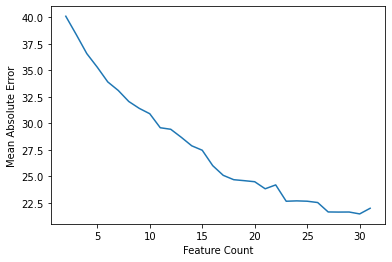

In [ ]:
plot_x = [i[0] for i in res]
plot_y = [i[1] for i in res]
plt.figure;
plt.plot(plot_x, plot_y)
plt.xlabel('Feature Count')
plt.ylabel('Mean Absolute Error')

In [ ]:
minError = float('inf')
minErrorIdx = -1
for idx, x in enumerate(res):
  if x[1] < minError:
    minError = x[1]
    minErrorIdx = idx
print('Minimum error seen : {}'.format(minError))
print('Selected columns : {}'.format(res[minErrorIdx][-2]))

Minimum error seen : 21.47108154296875
Selected columns : ['SCL' 'SCRamp' 'SCRfreq' 'HR' 'TEMP' 'ACC' 'IBI' 'RMSenergy' 'mfcc[1]'
 'mfcc[2]' 'mfcc[3]' 'mfcc[4]' 'mfcc[6]' 'mfcc[7]' 'mfcc[8]' 'mfcc[9]'
 'mfcc[10]' 'mfcc[11]' 'mfcc[12]' 'zcr' 'voiceProb' 'F0' 'pause_frequency'
 'Language' 'meanEDA' 'varEDA' 'modeEDA' 'meanHR' 'varHR' 'modeHR']


Based on the range of features used, it was found that **30 of the 32 columns were significant for prediction of State Anxiety** as given by the F-refression test. This is in contrast to what correlation coefficient showed (where only 10 of the features had coefficient whose absolute value was greater than 0.1).

In the second part of the feature selection methods, we have used **wrapper method** of **Recursive Feature Elimination with cross-validation(RFECV)**. Since wrapper method needs to be trained on a model, we have used gradient boost regressor model to train the wrapper method.

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

score_wrapper = []
score_wrapper_ac = []
feature_list = []
models = []
for i in range(4,X.shape[1],2):
	rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=i)
	X_matrix, Y_matrix = random_shuffle(X, Y)
	rfe.fit(X_matrix, Y_matrix)

	model = GradientBoostingRegressor()
	pipeline = Pipeline(steps=[('s',rfe),('m',model)])
	cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
	n_scores = cross_val_score(pipeline, X_matrix, Y_matrix, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	score_wrapper.append(-1*mean(n_scores))
	feature_names = [data.columns[i] for i in range(X.shape[1]) if rfe.support_[i]==True]
	feature_list.append(feature_names)

	score, model = get_score_FNN(data, feature_names, 5)

	score_wrapper_ac.append(score)

1/1 [==============================] - 0s 148ms/step - loss: 36.4119 - mean_absolute_error: 36.4119
Mean Absolute Error : [36.41192626953125, 36.41192626953125]
1/1 [==============================] - 0s 137ms/step - loss: 34.4689 - mean_absolute_error: 34.4689
Mean Absolute Error : [34.46891403198242, 34.46891403198242]
1/1 [==============================] - 0s 142ms/step - loss: 32.8374 - mean_absolute_error: 32.8374
Mean Absolute Error : [32.8373908996582, 32.8373908996582]
1/1 [==============================] - 0s 136ms/step - loss: 31.0783 - mean_absolute_error: 31.0783
Mean Absolute Error : [31.07834815979004, 31.07834815979004]
1/1 [==============================] - 0s 143ms/step - loss: 29.9007 - mean_absolute_error: 29.9007
Mean Absolute Error : [29.900726318359375, 29.900726318359375]
1/1 [==============================] - 0s 138ms/step - loss: 27.9260 - mean_absolute_error: 27.9260
Mean Absolute Error : [27.92599868774414, 27.92599868774414]
1/1 [=============================

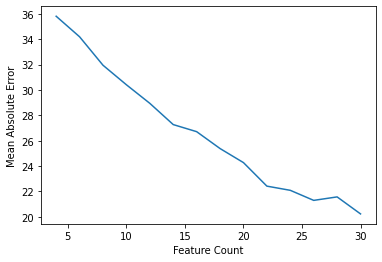

In [ ]:
plt.figure;
# plt.scatter(range(4,X.shape[1],2),score_wrapper_ac)
plt.plot(range(4,X.shape[1],2),score_wrapper_ac)
plt.xlabel('Feature Count')
plt.ylabel('Mean Absolute Error')
plt.show()

In [ ]:
best_features_index=score_wrapper_ac.index(min(score_wrapper_ac))
best_features=feature_list[best_features_index]
print('Number of features selected : {}'.format(len(best_features)))
print('Selected features : {}'.format(best_features))
print('Mean absolute error : {}'.format(min(score_wrapper)))

Number of features selected : 30
Selected features : ['SCL', 'SCRamp', 'SCRfreq', 'HR', 'BVP', 'TEMP', 'ACC', 'IBI', 'RMSenergy', 'mfcc[1]', 'mfcc[2]', 'mfcc[3]', 'mfcc[4]', 'mfcc[5]', 'mfcc[6]', 'mfcc[7]', 'mfcc[8]', 'mfcc[9]', 'mfcc[10]', 'mfcc[11]', 'mfcc[12]', 'zcr', 'voiceProb', 'F0', 'pause_frequency', 'meanEDA', 'varEDA', 'modeEDA', 'meanHR', 'varHR']
Mean absolute error : 8.254197837399348


**Observation:** Even for wrapper method, we saw that **30 features out of 32** **had an impact considerable enough**. The mean absolute error observed was 8.424.

In conclusion, both the feature selection methods - Filter and Wrapper methods, pointed out that we need 30 feautes out of 32 to know about the variations in state Anxiety and inturn predict about the same.

# **Question(c): Feature transformation**

---



### Use Principal Component Analysis (PCA) to reduce the dimensionality of the bio-behavioral features from D to K. Use a 5-fold cross-validation with a FNN model and experiment with dierent numbers of resulting dimensions K. You will run an outer loop that examines dierent K values. Following that, you will run an inner loop, that implements the 5-fold cross-validation for a given K. You will use the training data of each fold to compute the transformation matrix (i.e., by computing the eigenvalues and eigenvectors based on the training data), which will be then used to also transform the test data of each fold. At the end of the inner loop, you will compute the average absolute error across the five folds. Provide a plot of the average absolute error for all the dierent K values that you have experimented with.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

In [ ]:
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import sigmoid, relu
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
import matplotlib.pyplot as plt

def get_pca(np_data,np_label,data_len):
    components = []
    for i in range(2,(data_len+1)):
        components.append(i)
    print("Components under consideration",components)
    avg_error_k_train = []
    avg_error_k_val = []
    for k in components:
        print("Training for K = ",k)
        kf = KFold(n_splits=5, random_state=None, shuffle=True)
        error_train = []
        error_val = []
        for train_index, test_index in kf.split(np_data):
            pca = PCA(n_components=k)
            
            X_train, X_test = np_data[train_index], np_data[test_index]
            y_train, y_test = np_label[train_index], np_label[test_index]
            train_mean = np.mean(X_train,axis=0).T
            centered_data = (X_train - train_mean)
            centered_valid_data = X_test - train_mean 
            
            transformed_data = pca.fit_transform(centered_data) 
            
            tranformed_val_data = pca.transform(centered_valid_data) 
            
            model,history,_ = get_FNN(transformed_data,y_train)
            pred_train = model.evaluate(transformed_data, y_train)
            pred_val = model.evaluate(tranformed_val_data, y_test)
            error_train.append(pred_train[0])
            error_val.append(pred_val[0])
        avg_error_k_train.append(np.average(error_train))
        avg_error_k_val.append(np.average(error_val))
    return avg_error_k_train,avg_error_k_val,components


In [ ]:
def plot_validation_error(avg_error_val,components):
    print(avg_error_val)
    avg_val_min_index = np.argsort(avg_error_val)[:5]
    print(avg_val_min_index)
    #print(sorted(avg_error_k_val))
    k_list = [components[ele] for ele in avg_val_min_index]
    print('K values with least average validation error:',k_list)
    avg_minval_errors = [avg_error_val[idx] for idx in avg_val_min_index]
    print("Minimum Validation errors : {}".format(avg_minval_errors))

    plt.plot(components, avg_error_val)
    plt.xlabel("Number of components")
    plt.ylabel("Mean Absolute Error(Validation)")
    plt.title("PCA")
    plt.show()
    return avg_val_min_index

In [ ]:
#print(components[avg_error_k_train.index(min(avg_error_k_train))])
#print train error for K in K_list -> train error corresponding to K that gives the lease validation errors
def plot_train_error(avg_error_k_train,avg_val_min_index,components):
    for index in avg_val_min_index:
        print("Train error for {} components : {}".format(components[index],avg_error_k_train[index]))
    plt.plot(components, avg_error_k_train)
    plt.xlabel("Number of components")
    plt.ylabel("Mean Absolute Error(Training)")
    plt.title("PCA")
    plt.show()

In [ ]:
pca_data = data.copy(deep=True)
pca_data = pca_data.drop(columns=['meanEDA', 'varEDA', 'modeEDA', 'meanHR', 'varHR', 'modeHR'])

In [ ]:
pca_data.head(5)

SCL    SCRamp   SCRfreq  ...  pause_frequency  StateAnxiety  Language
PID                                 ...                                         
P001 -0.655278 -0.553061 -0.588335  ...         0.598270          62.0         2
P003 -0.608877 -0.644318 -0.086626  ...        -1.177278          41.0         1
P004 -0.778345 -0.995527 -2.226256  ...        -1.110814          39.0         2
P005 -0.331312 -0.637678  0.306730  ...        -0.256272          40.0         2
P006  1.016686  0.766389  1.322006  ...        -0.621395          50.0         2

[5 rows x 27 columns]

In [ ]:
np_data = np.array(pca_data.loc[:,pca_data.columns!='StateAnxiety'])
np_label = np.array(pca_data.loc[:,'StateAnxiety'])

In [ ]:
#PCA on original data
avg_error_k_train, avg_error_k_val, components_original = get_pca(np_data,np_label,np_data.shape[1])

Components under consideration [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Training for K =  2
1/1 [==============================] - 0s 23ms/step - loss: 36.4302 - mean_absolute_error: 36.4302
Training for K =  3
1/1 [==============================] - 0s 26ms/step - loss: 29.2752 - mean_absolute_error: 29.2752
Training for K =  4
1/1 [==============================] - 0s 25ms/step - loss: 33.3635 - mean_absolute_error: 33.3635
Training for K =  5
1/1 [==============================] - 0s 25ms/step - loss: 29.9203 - mean_absolute_error: 29.9203
Training for K =  6
1/1 [==============================] - 0s 22ms/step - loss: 23.5412 - mean_absolute_error: 23.5412
Training for K =  7
1/1 [==============================] - 0s 26ms/step - loss: 30.3867 - mean_absolute_error: 30.3867
Training for K =  8
1/1 [==============================] - 0s 23ms/step - loss: 31.9747 - mean_absolute_error: 31.9747
Training for K =  9
1/1 [==================

[36.95483474731445, 33.00803413391113, 31.609970474243163, 29.741133880615234, 28.556689071655274, 28.0739688873291, 27.165847778320312, 26.695490264892577, 25.97742614746094, 24.965250778198243, 24.643312454223633, 24.670312118530273, 23.689804458618163, 23.13858299255371, 22.926329040527342, 23.12537384033203, 22.467534637451173, 22.70340690612793, 22.22445602416992, 22.36417579650879, 22.321169662475587, 22.1634521484375, 21.84774513244629, 21.500016021728516, 22.049504852294923]
[23 22 24 21 18]
K values with least average validation error: [25, 24, 26, 23, 20]
Minimum Validation errors : [21.500016021728516, 21.84774513244629, 22.049504852294923, 22.1634521484375, 22.22445602416992]


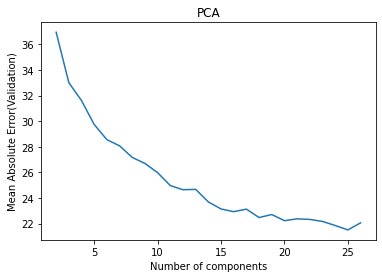

Train error for 25 components : 21.552962493896484
Train error for 24 components : 21.48977584838867
Train error for 26 components : 21.873949432373045
Train error for 23 components : 21.786854934692382
Train error for 20 components : 21.666108322143554


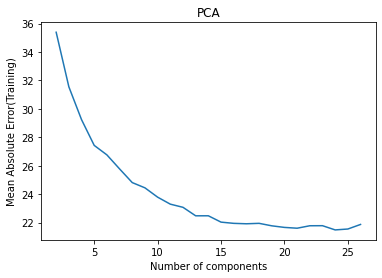

In [ ]:
avg_val_min_index = plot_validation_error(avg_error_k_val,components_original)
plot_train_error(avg_error_k_train,avg_val_min_index,components_original)

#**Question(d): Working with time-series**

---



###Next you will be using the time series constructed by the EDA and HR measures (i.e., \EDA PPT PXXX.xlsx" and \HR PPT PXXX.xlsx") to estimate state anxiety, in two ways: (1) Fit the time series using linear and non-linear regression models (i.e., input is time and output is the EDA or HR value). The parameters of the regression models (e.g., the bias and slope of the linear regression) will comprise the features of a FNN; and (2) Use a recurrent neural network (RNN) or long short-term memory (LSTM) network to model the temporal evolution of EDA and HR values in association to the state anxiety label. The output of the RNN/LSTM should be the state anxiety label. Experiment with a 5-fold cross-validation framework for both approaches using the average absolute error computed over all folds. Please report and discuss your findings.

**Soln** For non linear regressor, we have tried fitting the data to a polynomial of degree 4.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [ ]:
def getTS(pid, dtype='EDA'):
  fileNameTemplate = '{}_PPT_{}.xlsx'
  df = pd.read_excel(getFullPath(fileNameTemplate.format(dtype, pid)))
  return df

def getNPArray(df, dtype='EDA'):
  X = np.array(df['Time (s)']).reshape(-1, 1)
  Y = np.array(df[dtype])
  return X, Y

degree = 4
lrParams = []
prParams = []
for pid in list(data.index):
  edaDf = getTS(pid)
  hrDf = getTS(pid, dtype='HR')

  hrX, hrY = getNPArray(hrDf, dtype='HR')
  edaX, edaY = getNPArray(edaDf)
  hrReg = LinearRegression().fit(hrX, hrY)
  edaReg = LinearRegression().fit(edaX, edaY)

  polyEdaReg = make_pipeline(PolynomialFeatures(degree),LinearRegression())
  polyEdaReg = polyEdaReg.fit(edaX, edaY)
  polyHRReg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
  polyHRReg = polyHRReg.fit(hrX, hrY)

  lrParams.append((pid, edaReg.coef_[0], edaReg.intercept_, hrReg.coef_[0], hrReg.intercept_))
  prParams.append((pid, ) + tuple(polyEdaReg.steps[1][1].coef_[1:]) + (polyEdaReg.steps[1][1].intercept_, ) + tuple(polyHRReg.steps[1][1].coef_[1:]) + (polyHRReg.steps[1][1].intercept_, ))

In [ ]:
lrParamsDf = pd.DataFrame(lrParams).set_index(0)
prParamsDf = pd.DataFrame(prParams).set_index(0)

lrX = np.array(lrParamsDf.loc[:, :])
lrY = np.array(nonTemporalData.loc[:, 'StateAnxiety'])

prX = np.array(prParamsDf.loc[:, :])
prY = np.array(nonTemporalData.loc[:, 'StateAnxiety'])

prParamsDf

1             2   ...            9           10
0                             ...                          
P001 -0.000414 -1.176002e-05  ...  1.560256e-08   96.113481
P003 -0.001235  3.132628e-05  ... -2.134079e-07   75.151096
P004  0.000049 -5.326041e-07  ... -5.964701e-08  101.399338
P005 -0.001129  4.458007e-05  ... -4.757762e-07  102.785705
P006 -0.002504  1.438206e-05  ... -2.810626e-08   84.100508
P007 -0.004648  6.328182e-05  ...  4.310032e-08   90.166778
P008  0.008478 -1.545972e-04  ... -4.834317e-09   82.894046
P009 -0.000680 -8.136936e-06  ...  3.236450e-08  123.284706
P011 -0.004489  2.083265e-04  ...  7.504506e-08   92.353697
P012 -0.000446  1.468232e-05  ...  1.071084e-07   83.674483
P013  0.000691  9.884311e-06  ... -2.651519e-07   68.010768
P014  0.015026 -5.154021e-05  ... -7.773765e-08   91.118814
P016 -0.001298  3.816037e-05  ...  1.022086e-07   89.773372
P017  0.000284 -4.995228e-06  ... -8.979668e-07   95.080200
P018 -0.009284  2.914091e-04  ...  2.301505e-08  103.180776
P020  0.001552 -2.147266e-05  ... -8.592680e-08   75.157135
P021  0.017068 -8.445281e-04  ... -2.585803e-07   99.414276
P023  0.054801 -6.766170e-04  ...  1.164474e-07   84.145741
P026  0.001381 -2.562638e-05  ... -1.729164e-08   79.661209
P027  0.009279 -1.490149e-04  ...  5.701767e-09  109.829453
P031 -0.009367  1.559947e-04  ... -7.834182e-08   74.782304
P032  0.012050 -3.437438e-05  ... -8.733518e-08   83.414555
P035  0.000716 -5.517425e-05  ...  1.553134e-07  126.811756
P037  0.000644  3.481468e-05  ... -9.565682e-08  111.084371
P038 -0.004338  3.936344e-05  ...  1.756433e-06   78.015695
P039  0.001615 -2.778220e-05  ... -8.142333e-08   77.120388
P040 -0.006781 -4.135655e-04  ...  3.387325e-07  107.675067
P041 -0.001196  2.455342e-05  ... -1.315607e-07   62.162872
P042  0.036000 -5.084779e-04  ...  6.305722e-08  111.388251
P043 -0.007452  1.439691e-04  ... -7.296343e-08   83.992601
P044  0.001465 -2.341679e-05  ...  9.160070e-08   84.694678
P045 -0.009429  1.623153e-04  ... -2.506679e-07   92.769203
P046  0.001991 -2.161773e-05  ...  8.310853e-08   87.368109
P047  0.005303 -6.679494e-05  ...  3.916540e-08   80.297929
P048  0.004480 -3.482452e-05  ...  2.196635e-07   76.528761
P049  0.001985 -4.084902e-05  ...  9.516926e-08   74.770712
P050  0.043443 -5.886206e-04  ...  4.778149e-08   89.269881
P051  0.043267 -1.948157e-04  ... -3.294256e-07   76.935644
P052  0.039614 -4.785162e-04  ...  6.103847e-08   92.316149
P053 -0.000577  3.757552e-05  ... -1.374607e-07   80.054608
P056  0.003112 -4.607997e-05  ...  2.514632e-08  104.037045
P057  0.002261 -4.359143e-05  ... -2.825240e-07   75.351165
P058  0.004368 -7.580403e-05  ...  4.068199e-08  110.911260
P060  0.018124 -2.145863e-04  ... -1.435111e-08   64.166069
P061  0.006612 -1.204634e-04  ...  2.781680e-07  120.797763
P062  0.000118 -1.283246e-05  ... -2.287718e-07   92.317114
P063 -0.000301  4.603581e-06  ...  4.480836e-08   84.133794
P064  0.000853 -9.989953e-06  ...  1.223704e-07   79.352956
P065 -0.004870  1.628542e-04  ... -1.936994e-08  108.508129
P066  0.004078  2.351351e-05  ... -3.514347e-09   97.744647
P067 -0.013576  2.357207e-04  ...  3.542580e-07   88.384626
P068  0.002933 -5.070245e-05  ...  3.268472e-07   75.435384
P071  0.001195 -2.169861e-05  ...  2.557871e-07  100.229692
P072 -0.014194  2.342495e-04  ... -1.729417e-07  117.722548
P073 -0.072318  4.568439e-03  ...  2.716970e-07  109.292599

[55 rows x 10 columns]


We have used three different RNN models on the timeseries data. Each model used Adam optimiser and Mean absolute error as the loss function.


* Model one comprised of two layer of Gated Recurrent Unit (GRU) which use tanh as their activation fuction followed by a single dense neuron. Each layer of GRU has about 200 units. This model gave a validation loss of 9.48


* Model two comprised of 3 layers of Simple RNN units (300, 100, 200 respectively) and was followed by a single dense layer neuron. It was also interspersed by dropouts. Each of the RNN layer used has tanh as the activation function. This model gave a validation loss of 9.45

* Model three comprised of a single LSTM layer of 400, followed by a dense layer of 1 neuron. The LSTM layer used tanh as activation function. This model gave a validation loss of 9.40

In [ ]:
from itertools import zip_longest

maxLen = float('inf')
minPID = None
lstmX = []
lstmY = []
for pid in list(data.index):
  edaDf = getTS(pid)
  hrDf = getTS(pid, dtype='HR')
  if len(edaDf) < maxLen:
    minPID = pid
    maxLen = min(maxLen, len(edaDf))
  hrArr = np.array(hrDf['HR'].values[:110])
  arr = np.array(edaDf['EDA'].values[:440])
  edaList = list(edaDf['EDA'].values[:440])
  sbSample = []
  for i in range(3, 440, 4):
    mn = sum(edaList[i-3:i+1])/4
    sbSample.append(mn)
  arr = normalizeMaxMin(np.array(sbSample))
  hrArr = normalizeMaxMin(hrArr)
  carr = np.column_stack(zip(arr, hrArr))
  lstmX.append(carr.transpose())
lstmX = np.array(lstmX).reshape(55,110,2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [ ]:
timesteps = 110
features = 2

In [ ]:
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding, RepeatVector, TimeDistributed, GRU
from keras.regularizers import l2

model = Sequential()

model.add(GRU(200, activation='tanh', input_shape=(timesteps, features), return_sequences=True))
model.add(GRU(200, activation='tanh', return_sequences=True))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

history = model.fit(lstmX, Y.reshape(-1, 1), epochs=150, validation_split=0.2, verbose=1)



Epoch 1/150
2/2 [==============================] - 7s 964ms/step - loss: 46.5410 - val_loss: 45.2873
Epoch 2/150
2/2 [==============================] - 0s 118ms/step - loss: 45.7484 - val_loss: 44.2099
Epoch 3/150
2/2 [==============================] - 0s 115ms/step - loss: 44.5461 - val_loss: 42.1080
Epoch 4/150
2/2 [==============================] - 0s 124ms/step - loss: 42.1498 - val_loss: 37.6932
Epoch 5/150
2/2 [==============================] - 0s 119ms/step - loss: 37.4595 - val_loss: 32.2797
Epoch 6/150
2/2 [==============================] - 0s 120ms/step - loss: 32.3646 - val_loss: 29.5179
Epoch 7/150
2/2 [==============================] - 0s 120ms/step - loss: 29.9677 - val_loss: 28.5344
Epoch 8/150
2/2 [==============================] - 0s 114ms/step - loss: 29.0436 - val_loss: 27.8753
Epoch 9/150
2/2 [==============================] - 0s 115ms/step - loss: 28.4030 - val_loss: 27.3281
Epoch 10/150
2/2 [==============================] - 0s 116ms/step - loss: 27.8619 - val_los

In [ ]:
from keras.layers import SimpleRNN

model = Sequential()

model.add(SimpleRNN(300, activation='tanh', input_shape=(timesteps, features), return_sequences=True))
model.add(Dropout(0.25))
model.add(SimpleRNN(100, activation='tanh', return_sequences=True))
model.add(Dropout(0.35))
model.add(SimpleRNN(200, activation='tanh', return_sequences=True))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

history = model.fit(lstmX, Y.reshape(-1, 1), epochs=150, validation_split=0.2, verbose=1)



Epoch 1/150
2/2 [==============================] - 4s 927ms/step - loss: 45.6649 - val_loss: 39.5475
Epoch 2/150
2/2 [==============================] - 1s 503ms/step - loss: 40.6796 - val_loss: 36.1041
Epoch 3/150
2/2 [==============================] - 1s 472ms/step - loss: 37.2032 - val_loss: 33.3110
Epoch 4/150
2/2 [==============================] - 1s 445ms/step - loss: 34.4642 - val_loss: 31.1438
Epoch 5/150
2/2 [==============================] - 1s 438ms/step - loss: 32.2249 - val_loss: 29.5097
Epoch 6/150
2/2 [==============================] - 1s 441ms/step - loss: 30.4695 - val_loss: 28.3589
Epoch 7/150
2/2 [==============================] - 1s 498ms/step - loss: 29.1876 - val_loss: 27.5134
Epoch 8/150
2/2 [==============================] - 1s 450ms/step - loss: 28.2379 - val_loss: 26.8315
Epoch 9/150
2/2 [==============================] - 1s 457ms/step - loss: 27.4845 - val_loss: 26.2414
Epoch 10/150
2/2 [==============================] - 1s 451ms/step - loss: 26.8513 - val_los

In [ ]:
model1 = Sequential()

model1.add(LSTM(400, activation='tanh', input_shape=(timesteps, features)))
model1.add(Dense(1, kernel_initializer='normal',activation='linear'))
model1.compile(optimizer='adam', loss='mae')

history1 = model1.fit(lstmX, Y.reshape(-1, 1), epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
2/2 [==============================] - 3s 638ms/step - loss: 46.5693 - val_loss: 45.3305
Epoch 2/100
2/2 [==============================] - 0s 97ms/step - loss: 45.6618 - val_loss: 41.3142
Epoch 3/100
2/2 [==============================] - 0s 95ms/step - loss: 41.4509 - val_loss: 38.3864
Epoch 4/100
2/2 [==============================] - 0s 96ms/step - loss: 38.6536 - val_loss: 35.8937
Epoch 5/100
2/2 [==============================] - 0s 93ms/step - loss: 36.1580 - val_loss: 33.4849
Epoch 6/100
2/2 [==============================] - 0s 97ms/step - loss: 33.7947 - val_loss: 31.4554
Epoch 7/100
2/2 [==============================] - 0s 101ms/step - loss: 31.8269 - val_loss: 29.8622
Epoch 8/100
2/2 [==============================] - 0s 99ms/step - loss: 30.2813 - val_loss: 28.5813
Epoch 9/100
2/2 [==============================] - 0s 97ms/step - loss: 29.0291 - val_loss: 27.4860
Epoch 10/100
2/2 [==============================] - 0s 97ms/step - loss: 27.9505 - val_loss: 26.49

# **Question (f):** Examining individual differences <br>
###Examine individual differences with respect to the bio-behavioral features, state anxiety labels, and the models' decisions between native and non-native English speakers (1: native, 2: non-native in \data.csv"). What might be potential sources of these differences (if any)? Consider building group-specific models for estimating state anxiety for each group separately. Please discuss your results in comparison to the models obtained from the previous questions.
Group specific models (Native vs Non-native parts)
---
<br>

###**Soln**
Examining the influence of various features on axiety level predictions, we can see that the most correlated features for non-native speakers are very different from the most correlated features of native speakers. 
Theoretically, seggregating the data and training two diffrent models should help us predict the anxiety levels better. But the current data is skewed towards native speakers, resulting in a very small sample size for non-native speakers.<br>

Below are the mean absolute error values for various models<br>

PCA error for native speakers : 22.9 with K : 22<br>
PCA error for non-native speakers : 24.6 with K: 13<br>
PCA error on entire data : 21.5 with K: 25<br>

FNN error for native speakers : 24.2 <br>
FNN error for non-native speakers : 26.6<br>
FNN error on entire data with filter based feature selection : 22<br>
FNN error on entire data with wrapper based feature selection : 19.4<br>

We can see that the error for native speakers is very similar to the error obtained on the entire data as the number of smaples belonging to native speakers is higher. The error for non-native speakers is slighlty higher than the error on the entire data for both PCA and FNN.

In [ ]:
language_data = data.copy(deep=True)

In [ ]:
drop_columns = ['Language']
language_data = language_data.drop(columns=drop_columns)

In [ ]:
language_data.head(5)

SCL    SCRamp   SCRfreq  ...    meanHR     varHR    modeHR
PID                                 ...                              
P001 -0.655278 -0.553061 -0.588335  ... -0.994138  0.792538 -2.042087
P003 -0.608877 -0.644318 -0.086626  ...  0.293333 -0.585348 -0.221938
P004 -0.778345 -0.995527 -2.226256  ... -0.623302  0.024998 -0.551106
P005 -0.331312 -0.637678  0.306730  ... -0.078235 -0.071570 -0.483400
P006  1.016686  0.766389  1.322006  ... -0.882167 -0.949633 -0.533099

[5 rows x 32 columns]

In [ ]:
data.groupby('Language').size()

Language
1    38
2    17
dtype: int64

In [ ]:
native_df = language_data.loc[data['Language']==1]
non_native_df = language_data.loc[data['Language']==2]

In [ ]:
def get_correlations(dataf):
  corrData = []
  for x in dataf.keys():
    if x == 'StateAnxiety':
      continue
    corrData.append(('StateAnxiety', x, dataf['StateAnxiety'].corr(dataf.loc[:, x], method = 'pearson')))
  corrDf = pd.DataFrame(corrData, columns=['Label', 'Feature', 'Corr']).set_index('Feature').sort_values('Corr')
  corrDf['Abs'] = abs(corrDf['Corr'])
  return corrDf.sort_values('Abs',ascending=False)

In [ ]:
drop_features = ['meanHR','modeHR','varHR','meanEDA','modeEDA','varEDA']
native_df = native_df.drop(columns=drop_features)
non_native_df = non_native_df.drop(columns=drop_features)
native_corr = get_correlations(native_df)
non_native_corr = get_correlations(non_native_df)

In [ ]:
language_corrDf = pd.DataFrame(non_native_corr)
language_corrDf['Native Corr'] = native_corr['Corr']
language_corrDf['Native Abs'] = native_corr['Abs']

In [ ]:
language_corrDf

Label      Corr       Abs  Native Corr  Native Abs
Feature                                                                   
mfcc[4]          StateAnxiety  0.606539  0.606539    -0.084166    0.084166
voiceProb        StateAnxiety -0.446002  0.446002     0.152753    0.152753
F0               StateAnxiety -0.434284  0.434284     0.160386    0.160386
IBI              StateAnxiety  0.376901  0.376901     0.120558    0.120558
mfcc[2]          StateAnxiety  0.365389  0.365389    -0.082729    0.082729
ACC              StateAnxiety -0.327741  0.327741    -0.171415    0.171415
pause_frequency  StateAnxiety  0.273595  0.273595    -0.023109    0.023109
mfcc[6]          StateAnxiety  0.239159  0.239159    -0.119369    0.119369
mfcc[10]         StateAnxiety  0.212226  0.212226     0.091615    0.091615
mfcc[7]          StateAnxiety -0.188349  0.188349     0.034888    0.034888
mfcc[9]          StateAnxiety  0.160869  0.160869    -0.352328    0.352328
RMSenergy        StateAnxiety -0.152021  0.152021    -0.263553    0.263553
mfcc[3]          StateAnxiety  0.136900  0.136900    -0.237007    0.237007
zcr              StateAnxiety -0.128656  0.128656     0.086252    0.086252
mfcc[1]          StateAnxiety  0.115940  0.115940    -0.270496    0.270496
BVP              StateAnxiety -0.114048  0.114048     0.046506    0.046506
mfcc[11]         StateAnxiety  0.100789  0.100789    -0.094439    0.094439
mfcc[5]          StateAnxiety -0.058787  0.058787     0.027836    0.027836
mfcc[8]          StateAnxiety -0.058512  0.058512     0.100864    0.100864
SCL              StateAnxiety -0.047392  0.047392    -0.044676    0.044676
HR               StateAnxiety -0.028721  0.028721    -0.303565    0.303565
SCRamp           StateAnxiety -0.022335  0.022335    -0.023646    0.023646
TEMP             StateAnxiety -0.015948  0.015948    -0.200293    0.200293
SCRfreq          StateAnxiety -0.013870  0.013870     0.021253    0.021253
mfcc[12]         StateAnxiety  0.012657  0.012657     0.043857    0.043857

In [ ]:
def split_data(df):
    langFeatures = [x for x in df.columns if x != 'StateAnxiety']
    # print(len(featureCols))
    X = np.array(df.loc[:, langFeatures])
    Y = np.array(df.loc[:, 'StateAnxiety'])
    return X,Y

In [ ]:
native_X, native_Y = split_data(native_df)
native_train_mean = np.mean(native_X,axis=0).T
native_centered_data = (native_X - native_train_mean) #For FNN

In [ ]:
non_native_X, non_native_Y = split_data(non_native_df) #For PCA (internal centering done)
non_native_train_mean = np.mean(non_native_X,axis=0).T
non_native_centered_data = (non_native_X - non_native_train_mean) #For FNN

**FNN on segregated data**

In [ ]:
#FNN on native 
native_error,_ = get_score_FNN_alt(native_X,native_Y,5)
print('Avg Mean abs error for Native dataset:',native_error)

1/1 [==============================] - 0s 138ms/step - loss: 24.3376 - mean_absolute_error: 24.3376
Mean Absolute Error : 24.27504768371582
Avg Mean abs error for Native dataset: 24.27504768371582


In [ ]:
#FNN on  non native
non_native_error,_ = get_score_FNN_alt(non_native_X,non_native_Y,5)
print('Avg Mean abs error for non-Native dataset:',non_native_error)

1/1 [==============================] - 0s 143ms/step - loss: 36.0300 - mean_absolute_error: 36.0300
Mean Absolute Error : 26.631647491455077
Avg Mean abs error for non-Native dataset: 26.631647491455077


**PCA on segregated data:**

25
Components under consideration [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Training for K =  2
1/1 [==============================] - 0s 25ms/step - loss: 33.8333 - mean_absolute_error: 33.8333
Training for K =  3
1/1 [==============================] - 0s 23ms/step - loss: 34.6175 - mean_absolute_error: 34.6175
Training for K =  4
1/1 [==============================] - 0s 21ms/step - loss: 26.8165 - mean_absolute_error: 26.8165
Training for K =  5
1/1 [==============================] - 0s 24ms/step - loss: 26.6868 - mean_absolute_error: 26.6868
Training for K =  6
1/1 [==============================] - 0s 22ms/step - loss: 32.0515 - mean_absolute_error: 32.0515
Training for K =  7
1/1 [==============================] - 0s 24ms/step - loss: 31.4551 - mean_absolute_error: 31.4551
Training for K =  8
1/1 [==============================] - 0s 24ms/step - loss: 24.7905 - mean_absolute_error: 24.7905
Training for K =  9
1/1 [===================

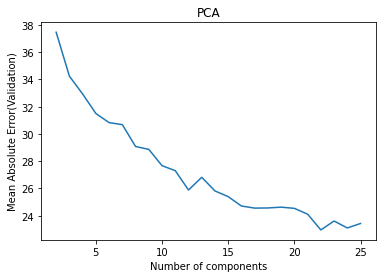

Native Speakers
Train error for 22 components : 23.18313331604004
Train error for 24 components : 23.44213523864746
Train error for 25 components : 23.38504753112793
Train error for 23 components : 23.30916633605957
Train error for 21 components : 23.43838577270508


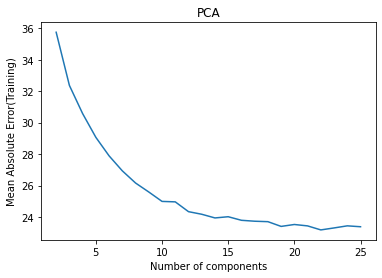

In [ ]:
#PCA on native
print(native_X.shape[1])
native_train_error,native_val_error,native_components = get_pca(native_X,native_Y,native_X.shape[1])
native_val_min_index = plot_validation_error(native_val_error,native_components)
print("Native Speakers")
plot_train_error(native_train_error,native_val_min_index,native_components)

Components under consideration [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Training for K =  2
1/1 [==============================] - 0s 25ms/step - loss: 33.3713 - mean_absolute_error: 33.3713
Training for K =  3
1/1 [==============================] - 0s 26ms/step - loss: 25.5079 - mean_absolute_error: 25.5079
Training for K =  4
1/1 [==============================] - 0s 23ms/step - loss: 24.2026 - mean_absolute_error: 24.2026
Training for K =  5
1/1 [==============================] - 0s 23ms/step - loss: 40.4531 - mean_absolute_error: 40.4531
Training for K =  6
1/1 [==============================] - 0s 22ms/step - loss: 23.1547 - mean_absolute_error: 23.1547
Training for K =  7
1/1 [==============================] - 0s 24ms/step - loss: 33.5227 - mean_absolute_error: 33.5227
Training for K =  8
1/1 [==============================] - 0s 23ms/step - loss: 32.2579 - mean_absolute_error: 32.2579
Training for K =  9
1/1 [==============================] - 0s 25ms/step - loss: 17.8051 - mean_

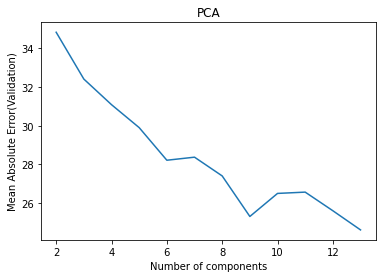

Non-native Speakers
Train error for 13 components : 22.259937286376953
Train error for 9 components : 22.676631927490234
Train error for 12 components : 22.098025131225587
Train error for 10 components : 22.514187240600585
Train error for 11 components : 22.54525489807129


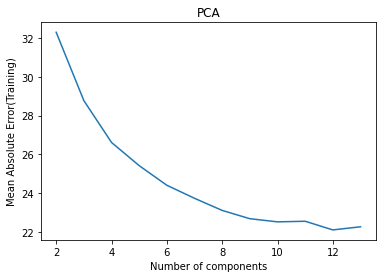

In [ ]:
#PCA on non-native
non_native_train_error,non_native_val_error,non_native_components = get_pca(non_native_X,non_native_Y,13)
non_native_val_min_index = plot_validation_error(non_native_val_error,non_native_components)
print("Non-native Speakers")
plot_train_error(non_native_train_error,non_native_val_min_index,non_native_components)

In [ ]:
!pip install lime

     |████████████████████████████████| 275 kB 11.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=53d90fefc9d3205c8e9c5f488712bc9b3051ef752ad20eac42560a0fdd3cb0ac
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


# **Question(e):** Interpreting the model decisions. 

---


###Based on the results that you obtained in questions (b) and (d), use an interpretable machine learning algorithm of your choice to better understand which part(s) of the data contributed to the algorithms decision. Discuss your findings using a few examples. Note: You can use existing toolboxes from Github, such as LIME (https://github.com/marcotcr/lime) and LIME for time (https://github.com/emanuel-metzenthin/Lime-For-Time).

**Soln** 

We had observed 30 out of the 32 features impacted the stateAnxiety level. With lime we can observe how those feature actually contribute towards the stateAnxeity levels. For example, language has  huge negative effect on the anxiety as shown by LIME. This is intuitive as well. We can expect a native speaker to be less tensed while speaking in his own mother tongue as to compared to a non native person speaking in English.

In [ ]:
import lime
import lime.lime_tabular

train = res[minErrorIdx][-1]
predictor = res[minErrorIdx][2]
featureNames = res[minErrorIdx][-2]
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=featureNames, 
                                                   class_names=['StateAnxiety'], 
                                                   verbose=True, mode='regression')
exp = explainer.explain_instance(train[10], predictor.predict, num_features=len(featureNames))
exp.show_in_notebook(show_table=True)

exp = explainer.explain_instance(train[30], predictor.predict, num_features=len(featureNames))
exp.show_in_notebook(show_table=True)

exp = explainer.explain_instance(train[50], predictor.predict, num_features=len(featureNames))
exp.show_in_notebook(show_table=True)

Intercept 28.634302777533122
Prediction_local [25.465404]
Right: 36.5253


Intercept 28.772934784911698
Prediction_local [25.07513412]
Right: 27.508297


Intercept 30.247912729896044
Prediction_local [21.24960074]
Right: 17.58834


In [ ]:
lrAcc = get_score_FNN_alt(lrX, lrY, 5)
lrAcc

1/1 [==============================] - 0s 152ms/step - loss: 12.8208 - mean_absolute_error: 12.8208
Mean Absolute Error : 10.033802795410157


(10.033802795410157, <keras.engine.sequential.Sequential at 0x7f465fa5cd90>)

# **Question (h):**

Brief description of the work and main results:<br>


---


**Team 7:** <br>

---


*  RMSEnergy,HR,ACC,mfcc[9] were the features that best represented the output.
*   Pearson Correlation filter method and Sequential forward selection wrapper methods were used for feature selection. 
* **Interesting aspect:** Average error for each dimension in 5 fold were plotted for comparative 
analysis of filter and wrapper methods. Wrapper method performed better than filter method.

* For PCA implementation, minimum absolute error was obtained for K=8.
*  LSTM had least loss and performed better than FNN or feature extraction methods. Quantitative loss values weren't mentioned.

---





**Team 1:**

---

*   Pearson Correlation filter method and forward selection wrapper methods were used for feature selection. 
*   PCA with k=7 and k=13 performed the best with 4 error.
*   **Interesting aspect:** Overlaying histogram of state anxiety with each feature looks good.
* Speech Fundamental Frequency(F0) and mel-frequency coefficients contribute the most as per the LIME interpretation diagram. 
* Team attributed the low performance of LSTM with 46 layers(~16 error) to the fact that native and non-native speakers are not balanced. 


---
**Team 10:**


---
* Filter method was faster but wrapper method with backward elimination provided a lower mean absolute error. 
* FNN had a Mean absolute error of 9.3 and LSTM had a lower mean absolute error of 8.69
* PCA with k=2 and k=16 yielded the least errors. 
* **Interesting aspect:** Most informative features for native were mfcc[9],HR,mfcc[1]. However,for non-native speakers, mfcc[4],voiceProb and F0 were the most important ones. 
* LIME interpretation diagram showed HRIntercept was the most indicative of Anxiety Level. 


---
**Team 9:**


---
* Pearson's Correlation Coefficient was used as filter method. 5  features (HR,ACC, RMSenergy,IBI and mfcc[9]) showed very weak correlation. 
* Forward selection was used as wrapper method. Features SCL,ACC,mcc coefficients had weak correlation. 
* Wrapper had lower mean absolute error than filter method. Computational time was similar with both methods. 
* **Interesting aspect:** Dendrogram and heatmap visualizations look very helpful in identifying correlation between different behavioural features. 
* PCA obtained the least average absolute error of 10.5 for K=6.
* LSTM performed the best with MAE of ~7.96
